In [1]:
# unable colab to access git
!git clone https://github.com/yifeica0/ECS171-Group8.git
%cd ECS171-Group8
!git checkout models

Cloning into 'ECS171-Group8'...
remote: Enumerating objects: 575, done.
remote: Counting objects: 100% (183/183), done.
remote: Compressing objects: 100% (131/131), done.
remote: Total 575 (delta 82), reused 143 (delta 50), pack-reused 392 (from 1)
Receiving objects: 100% (575/575), 176.07 MiB | 44.54 MiB/s, done.
Resolving deltas: 100% (240/240), done.
/content/ECS171-Group8
Branch 'models' set up to track remote branch 'models' from 'origin'.
Switched to a new branch 'models'


In [2]:
# update repo informations
!git pull

Already up to date.


In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc, RocCurveDisplay
from sklearn.preprocessing import LabelBinarizer

In [4]:
# load extended data for text sentiment
df = pd.read_parquet('datasets/extended_datasets/amazon_user_reviews_text_sentiment_extended.parquet')

df.head()

,sentiment,text_cleaned
0,2,imagine someone use skin worse using fine sand...
1,2,way small
2,2,absolutely junk bit even stay total waste mone...
3,2,smell great seen improvement keep trying see a...
4,2,broke less week heavy


In [6]:
# Drop rows where 'text_cleaned' is NaN or empty string
df.dropna(subset=['text_cleaned'], inplace=True)
df = df[df['text_cleaned'].str.strip() != '']

# Split data into features (X) and target (y)
X = df['text_cleaned']
y = df['sentiment']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training data size: {X_train.shape[0]} samples")
print(f"Testing data size: {X_test.shape[0]} samples")

# Initialize TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))

# Fit and transform the training data, transform the test data
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print(f"TF-IDF vocabulary size: {len(tfidf_vectorizer.vocabulary_)}")
print(f"Shape of X_train_tfidf: {X_train_tfidf.shape}")
print(f"Shape of X_test_tfidf: {X_test_tfidf.shape}")

Training data size: 29552 samples
Testing data size: 7388 samples
TF-IDF vocabulary size: 5000
Shape of X_train_tfidf: (29552, 5000)
Shape of X_test_tfidf: (7388, 5000)


### Model Training and Evaluation

#### Logistic Regression

In [7]:
# Initialize and train Logistic Regression model
lr_model = LogisticRegression(max_iter=1000, solver='liblinear', random_state=42)
lr_model.fit(X_train_tfidf, y_train)

# Predict on the test set
y_pred_lr = lr_model.predict(X_test_tfidf)

# Evaluate the model
print("Logistic Regression Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_lr):.4f}")
print(classification_report(y_test, y_pred_lr))

Logistic Regression Performance:
Accuracy: 0.6654
              precision    recall  f1-score   support

           0       0.73      0.75      0.74      2474
           1       0.59      0.54      0.56      2439
           2       0.66      0.71      0.69      2475

    accuracy                           0.67      7388
   macro avg       0.66      0.66      0.66      7388
weighted avg       0.66      0.67      0.66      7388



#### Multinomial Naive Bayes


In [8]:
# Initialize and train Multinomial Naive Bayes model
mnb_model = MultinomialNB()
mnb_model.fit(X_train_tfidf, y_train)

# Predict on the test set
y_pred_mnb = mnb_model.predict(X_test_tfidf)

# Evaluate the model
print("Multinomial Naive Bayes Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_mnb):.4f}")
print(classification_report(y_test, y_pred_mnb))

Multinomial Naive Bayes Performance:
Accuracy: 0.6520
              precision    recall  f1-score   support

           0       0.74      0.71      0.73      2474
           1       0.56      0.58      0.57      2439
           2       0.67      0.66      0.67      2475

    accuracy                           0.65      7388
   macro avg       0.65      0.65      0.65      7388
weighted avg       0.65      0.65      0.65      7388



#### Support Vector Machine (SVM)

In [9]:
# Initialize and train SVM model
# Using a linear kernel often works well for text data due to high dimensionality
svm_model = SVC(kernel='linear', random_state=42)
svm_model.fit(X_train_tfidf, y_train)

# Predict on the test set
y_pred_svm = svm_model.predict(X_test_tfidf)

# Evaluate the model
print("Support Vector Machine (SVM) Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_svm):.4f}")
print(classification_report(y_test, y_pred_svm))

Support Vector Machine (SVM) Performance:
Accuracy: 0.6528
              precision    recall  f1-score   support

           0       0.73      0.73      0.73      2474
           1       0.56      0.54      0.55      2439
           2       0.66      0.69      0.67      2475

    accuracy                           0.65      7388
   macro avg       0.65      0.65      0.65      7388
weighted avg       0.65      0.65      0.65      7388



#### Random Forest

In [10]:
# Initialize and train Random Forest model
# n_estimators is the number of trees in the forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train_tfidf, y_train)

# Predict on the test set
y_pred_rf = rf_model.predict(X_test_tfidf)

# Evaluate the model
print("Random Forest Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")
print(classification_report(y_test, y_pred_rf))

Random Forest Performance:
Accuracy: 0.6317
              precision    recall  f1-score   support

           0       0.69      0.71      0.70      2474
           1       0.55      0.53      0.54      2439
           2       0.65      0.66      0.65      2475

    accuracy                           0.63      7388
   macro avg       0.63      0.63      0.63      7388
weighted avg       0.63      0.63      0.63      7388



### Confusion Matrices visualization

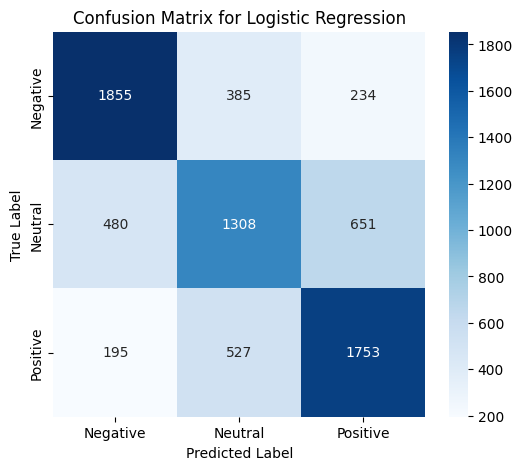

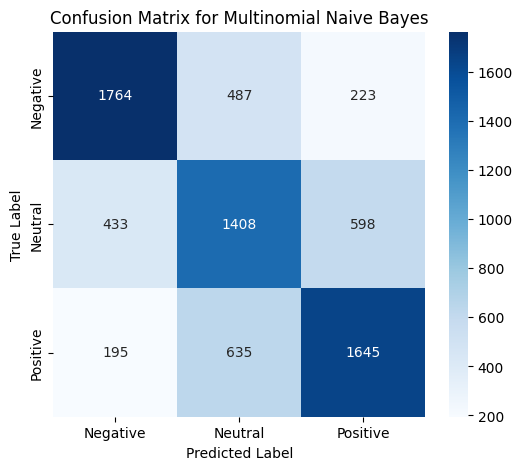

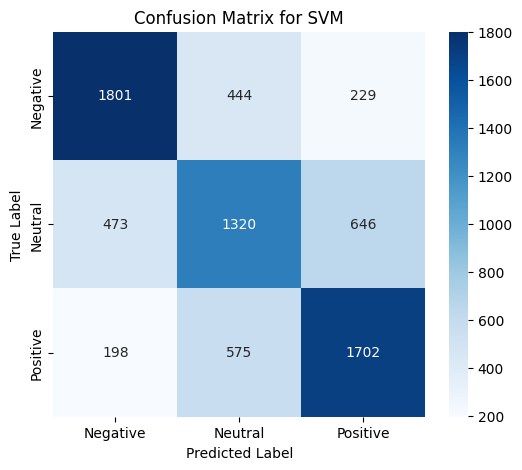

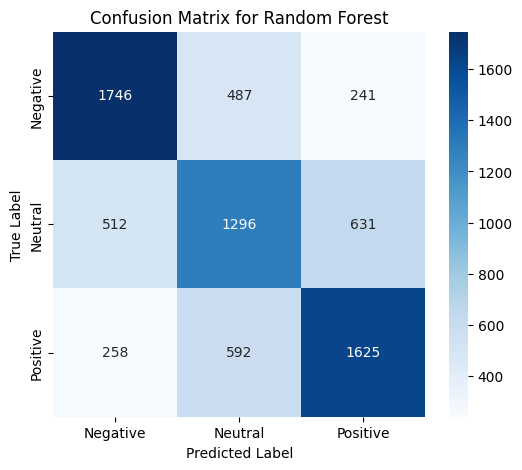

In [12]:
models = {
    "Logistic Regression": (lr_model, y_pred_lr),
    "Multinomial Naive Bayes": (mnb_model, y_pred_mnb),
    "SVM": (svm_model, y_pred_svm),
    "Random Forest": (rf_model, y_pred_rf)
}

for name, (model, y_pred) in models.items():
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Negative', 'Neutral', 'Positive'],
                yticklabels=['Negative', 'Neutral', 'Positive'])
    plt.title(f'Confusion Matrix for {name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

### ROC Curves Visualization

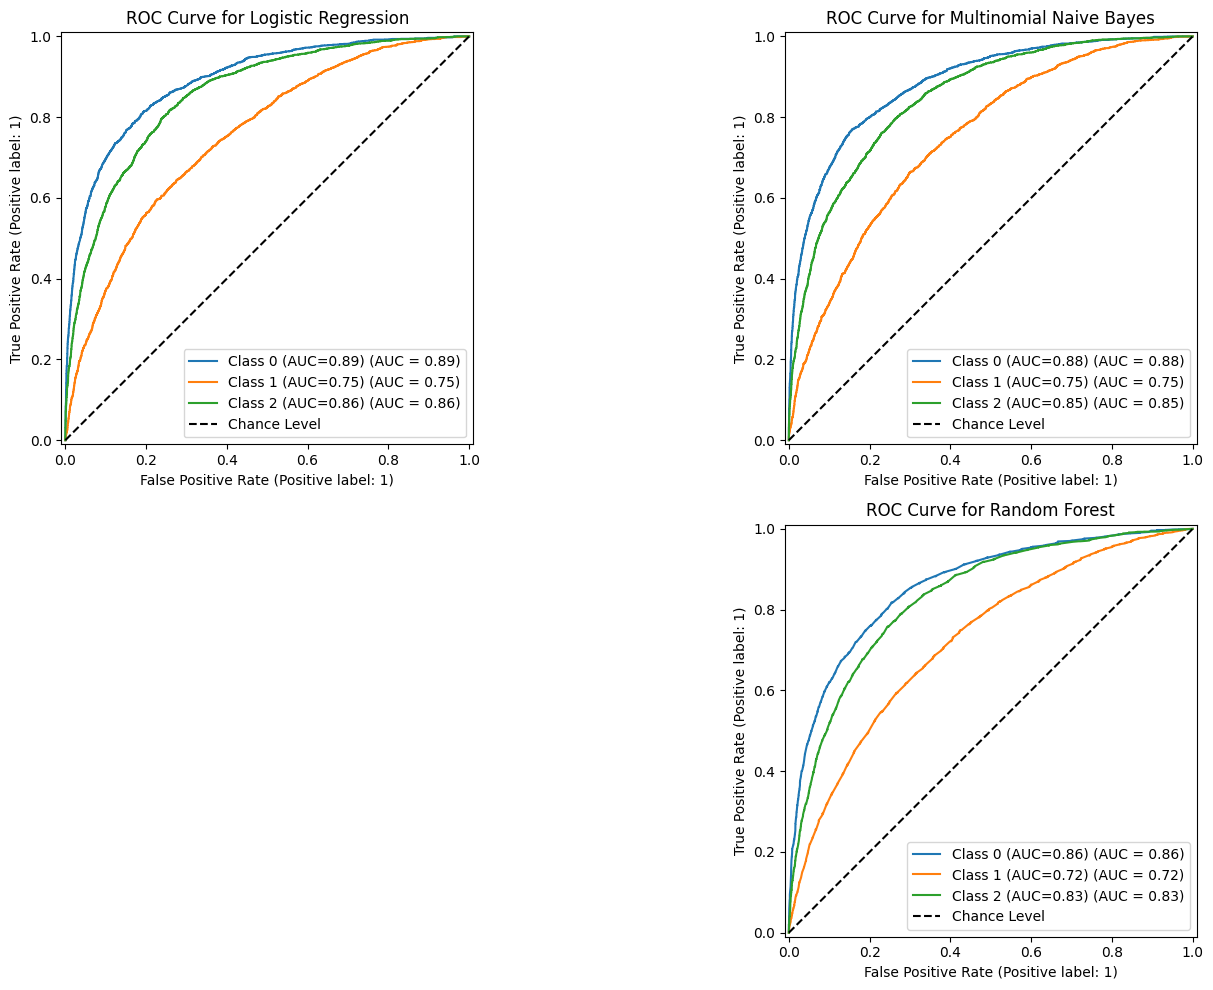

In [13]:
lb = LabelBinarizer()
# y_test_binarized will have columns for each class (0, 1, 2)
y_test_binarized = lb.fit_transform(y_test)


plt.figure(figsize=(15, 10))

# --- Logistic Regression ROC ---
plt.subplot(2, 2, 1)
y_score_lr = lr_model.predict_proba(X_test_tfidf)
RocCurveDisplay.from_predictions(y_test_binarized[:, 0], y_score_lr[:, 0], name=f'Class 0 (AUC={auc(roc_curve(y_test_binarized[:, 0], y_score_lr[:, 0])[0], roc_curve(y_test_binarized[:, 0], y_score_lr[:, 0])[1]):.2f})', pos_label=1, ax=plt.gca())
RocCurveDisplay.from_predictions(y_test_binarized[:, 1], y_score_lr[:, 1], name=f'Class 1 (AUC={auc(roc_curve(y_test_binarized[:, 1], y_score_lr[:, 1])[0], roc_curve(y_test_binarized[:, 1], y_score_lr[:, 1])[1]):.2f})', pos_label=1, ax=plt.gca())
RocCurveDisplay.from_predictions(y_test_binarized[:, 2], y_score_lr[:, 2], name=f'Class 2 (AUC={auc(roc_curve(y_test_binarized[:, 2], y_score_lr[:, 2])[0], roc_curve(y_test_binarized[:, 2], y_score_lr[:, 2])[1]):.2f})', pos_label=1, ax=plt.gca())
plt.title('ROC Curve for Logistic Regression')
plt.plot([0, 1], [0, 1], 'k--', label='Chance Level')
plt.legend()


# --- Multinomial Naive Bayes ROC ---
plt.subplot(2, 2, 2)
y_score_mnb = mnb_model.predict_proba(X_test_tfidf)
RocCurveDisplay.from_predictions(y_test_binarized[:, 0], y_score_mnb[:, 0], name=f'Class 0 (AUC={auc(roc_curve(y_test_binarized[:, 0], y_score_mnb[:, 0])[0], roc_curve(y_test_binarized[:, 0], y_score_mnb[:, 0])[1]):.2f})', pos_label=1, ax=plt.gca())
RocCurveDisplay.from_predictions(y_test_binarized[:, 1], y_score_mnb[:, 1], name=f'Class 1 (AUC={auc(roc_curve(y_test_binarized[:, 1], y_score_mnb[:, 1])[0], roc_curve(y_test_binarized[:, 1], y_score_mnb[:, 1])[1]):.2f})', pos_label=1, ax=plt.gca())
RocCurveDisplay.from_predictions(y_test_binarized[:, 2], y_score_mnb[:, 2], name=f'Class 2 (AUC={auc(roc_curve(y_test_binarized[:, 2], y_score_mnb[:, 2])[0], roc_curve(y_test_binarized[:, 2], y_score_mnb[:, 2])[1]):.2f})', pos_label=1, ax=plt.gca())
plt.title('ROC Curve for Multinomial Naive Bayes')
plt.plot([0, 1], [0, 1], 'k--', label='Chance Level')
plt.legend()


# --- SVM (SVC) ROC (Requires probability=True during SVC initialization to get predict_proba) ---
# As SVM was initialized without probability=True, we can't directly use predict_proba.
# If you need ROC for SVM, you would need to re-initialize and retrain it with probability=True.
# For now, we will skip SVM ROC or provide a placeholder.
# If probability=True was set, the code would look like this:
# plt.subplot(2, 2, 3)
# y_score_svm = svm_model.predict_proba(X_test_tfidf)
# RocCurveDisplay.from_predictions(y_test_binarized[:, 0], y_score_svm[:, 0], name=f'Class 0 (AUC={auc(roc_curve(y_test_binarized[:, 0], y_score_svm[:, 0])[0], roc_curve(y_test_binarized[:, 0], y_score_svm[:, 0])[1]):.2f})', pos_label=1, ax=plt.gca())
# ... and so on for other classes
# plt.title('ROC Curve for SVM')
# plt.plot([0, 1], [0, 1], 'k--', label='Chance Level')
# plt.legend()


# --- Random Forest ROC ---
plt.subplot(2, 2, 4)
y_score_rf = rf_model.predict_proba(X_test_tfidf)
RocCurveDisplay.from_predictions(y_test_binarized[:, 0], y_score_rf[:, 0], name=f'Class 0 (AUC={auc(roc_curve(y_test_binarized[:, 0], y_score_rf[:, 0])[0], roc_curve(y_test_binarized[:, 0], y_score_rf[:, 0])[1]):.2f})', pos_label=1, ax=plt.gca())
RocCurveDisplay.from_predictions(y_test_binarized[:, 1], y_score_rf[:, 1], name=f'Class 1 (AUC={auc(roc_curve(y_test_binarized[:, 1], y_score_rf[:, 1])[0], roc_curve(y_test_binarized[:, 1], y_score_rf[:, 1])[1]):.2f})', pos_label=1, ax=plt.gca())
RocCurveDisplay.from_predictions(y_test_binarized[:, 2], y_score_rf[:, 2], name=f'Class 2 (AUC={auc(roc_curve(y_test_binarized[:, 2], y_score_rf[:, 2])[0], roc_curve(y_test_binarized[:, 2], y_score_rf[:, 2])[1]):.2f})', pos_label=1, ax=plt.gca())
plt.title('ROC Curve for Random Forest')
plt.plot([0, 1], [0, 1], 'k--', label='Chance Level')
plt.legend()

plt.tight_layout()
plt.show()